# Train a $\pi^{+}$ vs. $e^{+}$ model using a deep neural network and a BDT

This notebook was developed and tested with Keras version 2.0.6. If you are using an older version, you might encounter problems with imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.6'

In [3]:
! nvidia-smi

Mon Aug 21 07:41:54 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:01:00.0     Off |                  N/A |
| 38%   49C    P8     6W / 180W |   7835MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GT 720      Off  | 0000:02:00.0     N/A |                  N/A |
| N/A   39C    P8    N/A /  N/A |      9MiB /   979MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
from functools import partial
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import (Dense, Reshape, Conv2D, LeakyReLU, BatchNormalization,
                          LocallyConnected2D, Activation, ZeroPadding2D,
                          Dropout, Lambda, Flatten, Input, add)

from keras.layers.merge import concatenate, multiply
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, classification_report

In [5]:
from calodata.features import extract_features

In [6]:
# shortcut function 'concat' will represent np.concatenate across the 0th axis
concat = partial(np.concatenate, axis=0)

In [7]:
def load_calodata(fpaths):
    '''
    Returns:
    --------
        data: a list of 3 numpy arrays, representing the energy deposition in each layer
            for a group of showers contained in the file 'fpath'
    '''
    for fpath in fpaths:
        with h5py.File(fpath, 'r') as h5:
            try:
                data = [concat((data[i], h5['layer_{}'.format(i)][:])) for i in xrange(3)]
            except NameError:
                data = [h5['layer_{}'.format(i)][:] for i in xrange(3)]
    return data

Choose which binary classification task to focus on

In [8]:
CLASS_ONE = 'gamma'
CLASS_TWO = 'eplus'

# CLASS_ONE = 'piplus'
# CLASS_TWO = 'eplus'

In [9]:
import glob
print 'Extraing data for ' + CLASS_ONE
# c1 = load_calodata(glob.glob(('../data/classification/{}_extra.hdf5').format(CLASS_ONE)))
c1 = load_calodata(glob.glob(('../../fast/{}_angle_position_5deg_xy.h5').format(CLASS_ONE)))
print 'Extraing data for ' + CLASS_TWO
# c2 = load_calodata(glob.glob(('../data/classification/{}_extra.hdf5').format(CLASS_TWO)))
c2 = load_calodata(glob.glob(('../../fast/{}_angle_position_5deg_xy.h5').format(CLASS_TWO)))
data = map(concat, zip(c1, c2))

labels = np.array([1] * c1[0].shape[0] + [0] * c2[0].shape[0])

Extraing data for gamma
Extraing data for eplus


In [10]:
# import glob
# print 'Extraing data for ' + CLASS_ONE
# c1_old = load_calodata(glob.glob(('../data/classification/{}.hdf5').format(CLASS_ONE)))
# print 'Extraing data for ' + CLASS_TWO
# c2_old = load_calodata(glob.glob(('../data/classification/{}.hdf5').format(CLASS_TWO)))
# data_old = map(concat, zip(c1_old, c2_old))

# labels_old = np.array([1] * c1_old[0].shape[0] + [0] * c2_old[0].shape[0])

In [11]:
print 'Number of {} events = {}'.format(CLASS_ONE, c1[0].shape[0])
print 'Number of {} events = {}'.format(CLASS_TWO, c2[0].shape[0])

Number of gamma events = 500000
Number of eplus events = 400000


Use a pre-written module to calculate the shower shape variables for the showers in our dataset and save them in an object called 'features'

In [12]:
features = extract_features(data) # shower shapes

In [13]:
# features_old = extract_features(data_old) # shower shapes

In [14]:
features.shape

(900000, 20)

In [15]:
# for f, fold in zip(features.T, features_old.T):
#     plt.figure(figsize=(10,10))
#     bins = np.linspace(f.min(), f.max(), 20)
#     _ = plt.hist(f[labels==0], bins=bins, label='f 0', normed=True, histtype='step')
#     _ = plt.hist(f[labels==1], bins=bins, label='f 1', normed=True, histtype='step')
#     _ = plt.hist(fold[labels_old==0], bins=bins, label='old 0', normed=True, histtype='step')
#     _ = plt.hist(fold[labels_old==1], bins=bins, label='old 1', normed=True, histtype='step')
#     plt.legend()
#     plt.show()

For no good reason, we are shuffling and splitting into train and test set by hand. 

TO-DO: use sklearn train_test_split

TO-DO: save out a final validation set as well

In [15]:
# random shuffle
np.random.seed(0)
ix = np.array(range(len(labels)))
np.random.shuffle(ix)

# number of examples to train on
nb_train = int(0.7 * len(ix))

# train test split
ix_train = ix[:nb_train]
ix_test = ix[nb_train:]

features_train = features[ix_train]
data_train = [np.expand_dims(d[ix_train], -1) / 1000. for d in data]
labels_train = labels[ix_train]

features_test = features[ix_test]
data_test = [np.expand_dims(d[ix_test], -1) / 1000. for d in data]
labels_test = labels[ix_test]

In [16]:
raveled_train = np.concatenate([d.reshape(d.shape[0], -1) for d in data_train], axis=-1)
raveled_test = np.concatenate([d.reshape(d.shape[0], -1) for d in data_test], axis=-1)

# LAGAN-style discriminator

In [17]:
def build_model(image, selu=True, bn=True):
    '''
    Build LAGAN-style discriminator
    '''
    x = Conv2D(64, (2, 2), padding='same')(image)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D((1, 1))(image)
#     x = LocallyConnected2D(8 * 4, (3, 3), padding='valid', strides=(1, 2))(x)
    x = Conv2D(8 * 4, (3, 3), padding='valid', strides=(1, 2))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D((1, 1))(x)
#     x = LocallyConnected2D(16 * 4, (2, 2), padding='valid')(x)
    x = Conv2D(16 * 4, (2, 2), padding='valid')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D((1, 1))(x)
#     x = LocallyConnected2D(32 * 4, (2, 2), padding='valid', strides=(1, 2))(x)
    x = Conv2D(32 * 4, (2, 2), padding='valid', strides=(1, 2))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)

    return x

In [18]:
shapes = [d.shape[1:] for d in data_train]

x = [Input(shape=sh) for sh in shapes]

h = concatenate(map(partial(build_model), x)) 

h = Dense(256)(h)
h = Activation('relu')(h)
h = Dropout(0.5)(h)

y = Dense(1, activation='sigmoid')(h)

image_dnn = Model(x, y)
image_dnn.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [19]:
image_dnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 96, 1)      0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 12, 12, 1)     0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 12, 6, 1)      0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 5, 98, 1)      0           input_1[0][0]                    
___________________________________________________________________________________________

In [20]:
callbacks = [
    EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
    ModelCheckpoint('LAGAN{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True),
]

In [42]:
try:
    image_dnn.fit(data_train, labels_train, callbacks=callbacks, verbose=True,
                  validation_split=0.3, batch_size=128, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 441000 samples, validate on 189000 samples
Epoch 1/100
441000/441000 [==============================] - 124s - loss: 0.6213 - acc: 0.6217 - val_loss: 0.6561 - val_acc: 0.5440
Epoch 2/100
441000/441000 [==============================] - 122s - loss: 0.6015 - acc: 0.6363 - val_loss: 0.5887 - val_acc: 0.6509
Epoch 3/100
441000/441000 [==============================] - 121s - loss: 0.5974 - acc: 0.6408 - val_loss: 0.5865 - val_acc: 0.6494
Epoch 4/100
441000/441000 [==============================] - 120s - loss: 0.5963 - acc: 0.6418 - val_loss: 0.5848 - val_acc: 0.6538
Epoch 5/100
441000/441000 [==============================] - 120s - loss: 0.5952 - acc: 0.6426 - val_loss: 0.5831 - val_acc: 0.6544
Epoch 6/100
441000/441000 [==============================] - 120s - loss: 0.5931 - acc: 0.6451 - val_loss: 0.5928 - val_acc: 0.6408
Epoch 7/100
441000/441000 [==============================] - 120s - loss: 0.5930 - acc: 0.6464 - val_loss: 0.5809 - val_acc: 0.6562
Epoch 8/100
441000/44100

In [21]:
image_dnn.load_weights('LAGAN{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
image_dnn.save_weights('LAGAN{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [22]:
image_dnn.load_weights('LAGAN{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [23]:
# with h5py.File('LAGAN{}vs{}-split-indices.h5'.format(CLASS_ONE, CLASS_TWO), 'w') as h5:
#     h5['train'] = ix_train
#     h5['test'] = ix_test

In [24]:
yhat_image_dnn = image_dnn.predict(data_test, verbose=True).ravel()

269888/270000 [============================>.] - ETA: 0s

# Train a DNN on shower shapes

In [25]:
def build_feature_dnn(x):

    h = Dense(256)(x)
    h = Dropout(0.2)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(256)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(256)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)
    
    h = Dense(256)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(32)(h)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = Dense(1)(h)
    y = Activation('sigmoid')(h)
    

    return y

In [26]:
x = Input(shape=(features_train.shape[1], ))
feature_dnn = Model(x, build_feature_dnn(x))
feature_dnn.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [27]:
feature_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               5376      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
__________

In [28]:
callbacks = [
    EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
    ModelCheckpoint('SS{}vs{}-features-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True),
]

In [29]:
try:
    feature_dnn.fit(features_train / features_train.max(axis=0)[np.newaxis, :], labels_train, callbacks=callbacks, verbose=True,
                  validation_split=0.3, batch_size=128, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 441000 samples, validate on 189000 samples
Epoch 1/100
 41088/441000 [=>............................] - ETA: 26s - loss: 0.7080 - acc: 0.5870ending early


In [30]:
feature_dnn.load_weights('SS{}vs{}-features-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
feature_dnn.save_weights('SS{}vs{}-features-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [31]:
feature_dnn.load_weights('SS{}vs{}-features-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [32]:
yhat_feature_dnn = feature_dnn.predict(features_test / features_test.max(axis=0)[np.newaxis, :], verbose=True).ravel()

269632/270000 [============================>.] - ETA: 0s

# Train a BDT on shower shapes

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
base_clf = GradientBoostingClassifier(verbose=2)
parameters = {
    'n_estimators':[100, 200, 300],
    'max_depth':[3, 5]
}

In [ ]:
clf = GridSearchCV(base_clf, parameters, n_jobs=7)

In [ ]:
clf.best_params_

In [ ]:
clf.fit(features_train, labels_train)

In [ ]:
yhat_feature_bdt = clf.predict_proba(features_test)[:, 1].ravel()


# Train simple DNN on pix

In [33]:
def build_simple_dnn(x):

    h = Dense(512)(x)
    h = Dropout(0.2)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(1024)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(2048)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)
    
    h = Dense(1024)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(128)(h)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = Dense(1)(h)
    y = Activation('sigmoid')(h)
    

    return y

In [34]:
x = Input(shape=(raveled_train.shape[1], ))
raveled_dnn = Model(x, build_simple_dnn(x))
raveled_dnn.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [35]:
raveled_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 504)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               258560    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 1024)              0         
__________

In [36]:
callbacks = [
    EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
    ModelCheckpoint('PixVec{}vs{}-raveled-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True),
]

In [34]:
try:
    raveled_dnn.fit(raveled_train, labels_train, callbacks=callbacks, verbose=True,
                          validation_split=0.3, batch_size=128, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 441000 samples, validate on 189000 samples
Epoch 1/100
441000/441000 [==============================] - 42s - loss: 0.6343 - acc: 0.6203 - val_loss: 0.6067 - val_acc: 0.6355
Epoch 2/100
441000/441000 [==============================] - 40s - loss: 0.6110 - acc: 0.6335 - val_loss: 0.6059 - val_acc: 0.6383
Epoch 3/100
441000/441000 [==============================] - 40s - loss: 0.6101 - acc: 0.6334 - val_loss: 0.6061 - val_acc: 0.6380
Epoch 4/100
441000/441000 [==============================] - 41s - loss: 0.6088 - acc: 0.6353 - val_loss: 0.6045 - val_acc: 0.6383
Epoch 5/100
441000/441000 [==============================] - 41s - loss: 0.6077 - acc: 0.6364 - val_loss: 0.6021 - val_acc: 0.6391
Epoch 6/100
441000/441000 [==============================] - 41s - loss: 0.6072 - acc: 0.6364 - val_loss: 0.6021 - val_acc: 0.6404
Epoch 7/100
441000/441000 [==============================] - 41s - loss: 0.6070 - acc: 0.6369 - val_loss: 0.6021 - val_acc: 0.6402
Epoch 8/100
441000/441000 [====

In [37]:
raveled_dnn.load_weights('PixVec{}vs{}-raveled-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
raveled_dnn.save_weights('PixVec{}vs{}-raveled-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [38]:
raveled_dnn.load_weights('PixVec{}vs{}-raveled-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [39]:
yhat_raveled_dnn = raveled_dnn.predict(raveled_test, verbose=True).ravel()

269856/270000 [============================>.] - ETA: 0s

# Train DenseNet

In [40]:
import sys

In [41]:
sys.path.append('/home/micky/keras-contrib')

In [42]:
% cd ~/keras-contrib/keras_contrib/applications/
% run densenet.py
#from densenet import DenseNet as build_densenet
% cd /home/micky/CaloGAN/classification/

/home/micky/keras-contrib/keras_contrib/applications
/home/micky/CaloGAN/classification


In [43]:
build_densenet = DenseNet

In [63]:
# to support 1 channel images, just comment out the input_shape = _obtain_input_shape part
# just set the input_shape when you build the model (risky without checks)

In [18]:
dnet1 = build_densenet(weights=None, classes=1, activation='sigmoid',
                       input_shape=(12, 12, 1), nb_dense_block=1,
                      include_top=True)

densenet.py:507: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., activation="sigmoid", bias_regularizer=<keras.reg...)`


In [20]:
dnet1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 12, 12, 1)     0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 12, 12, 16)    144         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 12, 12, 16)    64          initial_conv2D[0][0]             
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 12, 12, 16)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [21]:
#from keras.utils.vis_utils import plot_model

In [22]:
#plot_model(dnet, to_file='dnet.png', show_shapes=True)

In [23]:
#from IPython.display import Image
#Image(filename='dnet.png') 

In [19]:
dnet1.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [25]:
callbacks = [
    EarlyStopping(verbose=True, patience=20, monitor='val_loss'),
    ModelCheckpoint('DenseNet1{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True),
]

In [30]:
# Train a Dense Net only on the middle layer
try:
    dnet1.fit(data_train[1], labels_train, callbacks=callbacks, verbose=True,
                  validation_split=0.3, batch_size=256, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 127s - loss: 0.0304 - acc: 0.9937 - val_loss: 0.0840 - val_acc: 0.9794
Epoch 2/100
489999/489999 [==============================] - 125s - loss: 0.0300 - acc: 0.9938 - val_loss: 0.1758 - val_acc: 0.9652
Epoch 3/100
489999/489999 [==============================] - 126s - loss: 0.0294 - acc: 0.9939 - val_loss: 1.3075 - val_acc: 0.7699
Epoch 4/100
489999/489999 [==============================] - 126s - loss: 0.0288 - acc: 0.9940 - val_loss: 0.0530 - val_acc: 0.9866
Epoch 5/100
489999/489999 [==============================] - 125s - loss: 0.0288 - acc: 0.9939 - val_loss: 1.3921 - val_acc: 0.7879
Epoch 6/100
489999/489999 [==============================] - 125s - loss: 0.0286 - acc: 0.9939 - val_loss: 0.1766 - val_acc: 0.9405
Epoch 7/100
489999/489999 [==============================] - 125s - loss: 0.0282 - acc: 0.9939 - val_loss: 0.0465 - val_acc: 0.9862
Epoch 8/100
489999/48999

489999/489999 [==============================] - 126s - loss: 0.0259 - acc: 0.9942 - val_loss: 1.5563 - val_acc: 0.5760
Epoch 64/100
489999/489999 [==============================] - 126s - loss: 0.0249 - acc: 0.9945 - val_loss: 0.9741 - val_acc: 0.7414
Epoch 65/100
489999/489999 [==============================] - 126s - loss: 0.0252 - acc: 0.9944 - val_loss: 0.0468 - val_acc: 0.9873
Epoch 66/100
489999/489999 [==============================] - 126s - loss: 0.0248 - acc: 0.9944 - val_loss: 1.6008 - val_acc: 0.6975
Epoch 67/100
489999/489999 [==============================] - 126s - loss: 0.0251 - acc: 0.9944 - val_loss: 2.1769 - val_acc: 0.6182
Epoch 68/100
489999/489999 [==============================] - 126s - loss: 0.0247 - acc: 0.9945 - val_loss: 0.0353 - val_acc: 0.9914
Epoch 69/100
489999/489999 [==============================] - 126s - loss: 0.0248 - acc: 0.9945 - val_loss: 0.0630 - val_acc: 0.9853
Epoch 70/100
489999/489999 [==============================] - 126s - loss: 0.0248 

In [20]:
dnet1.load_weights('DenseNet1{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
dnet1.save_weights('DenseNet1{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [22]:
dnet1.load_weights('DenseNet1{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [21]:
yhat_dnet = dnet1.predict(data_test[1], verbose=True).ravel()

299872/300000 [============================>.] - ETA: 0s

In [29]:
build_densenet?

In [32]:
dnet0 = build_densenet(weights=None, classes=1, activation='sigmoid',
                       input_shape=(3, 96, 1),
                       nb_dense_block=1, bottleneck=False) 
# ugly shapes, but ok

<string>:508: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., activation="sigmoid", bias_regularizer=<keras.reg...)`


In [33]:
dnet0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 96, 1)      0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 3, 96, 16)     144         input_2[0][0]                    
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 3, 96, 16)     0           initial_conv2D[0][0]             
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 3, 96, 12)     1728        activation_2[0][0]               
___________________________________________________________________________________________

In [34]:
dnet0.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [38]:
# Train a Dense Net only on the first layer
try:
    dnet0.fit(data_train[0], labels_train, 
              callbacks=[
                  EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                  ModelCheckpoint('DenseNet0{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True)
              ],
              verbose=True, validation_split=0.3, batch_size=256, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 103s - loss: 0.1055 - acc: 0.9781 - val_loss: 0.0747 - val_acc: 0.9896
Epoch 2/100
489999/489999 [==============================] - 105s - loss: 0.0637 - acc: 0.9894 - val_loss: 0.0596 - val_acc: 0.9907
Epoch 3/100
489999/489999 [==============================] - 105s - loss: 0.0558 - acc: 0.9911 - val_loss: 0.0516 - val_acc: 0.9924
Epoch 4/100
489999/489999 [==============================] - 105s - loss: 0.0505 - acc: 0.9921 - val_loss: 0.0492 - val_acc: 0.9928
Epoch 5/100
489999/489999 [==============================] - 105s - loss: 0.0480 - acc: 0.9926 - val_loss: 0.0467 - val_acc: 0.9928
Epoch 6/100
489999/489999 [==============================] - 105s - loss: 0.0459 - acc: 0.9929 - val_loss: 0.0661 - val_acc: 0.9885
Epoch 7/100
489999/489999 [==============================] - 105s - loss: 0.0439 - acc: 0.9930 - val_loss: 0.0799 - val_acc: 0.9856
Epoch 8/100
489999/48999

In [39]:
dnet0.load_weights('DenseNet0{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
dnet0.save_weights('DenseNet0{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))
dnet0.load_weights('DenseNet0{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [40]:
yhat_dnet0 = dnet0.predict(data_test[0], verbose=True).ravel()

299552/300000 [============================>.] - ETA: 0s

In [45]:
dnet2 = build_densenet(weights=None, classes=1, activation='sigmoid',
                       input_shape=(12, 6, 1), nb_dense_block=1, bottleneck=False)
# it doesn't work with nb_dense_block=3

In [46]:
dnet2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 12, 6, 1)      0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 12, 6, 16)     144         input_6[0][0]                    
____________________________________________________________________________________________________
activation_15 (Activation)       (None, 12, 6, 16)     0           initial_conv2D[0][0]             
____________________________________________________________________________________________________
conv2d_13 (Conv2D)               (None, 12, 6, 12)     1728        activation_15[0][0]              
___________________________________________________________________________________________

In [49]:
dnet2.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [50]:
# Train a Dense Net only on the last layer
try:
    dnet2.fit(data_train[2], labels_train, 
              callbacks=[
                  EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                  ModelCheckpoint('DenseNet2{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True)
              ],
              verbose=True, validation_split=0.3, batch_size=256, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 41s - loss: 0.2031 - acc: 0.9456 - val_loss: 0.1574 - val_acc: 0.9632
Epoch 2/100
489999/489999 [==============================] - 41s - loss: 0.1602 - acc: 0.9617 - val_loss: 0.1447 - val_acc: 0.9664
Epoch 3/100
489999/489999 [==============================] - 41s - loss: 0.1494 - acc: 0.9638 - val_loss: 0.1355 - val_acc: 0.9672
Epoch 4/100
489999/489999 [==============================] - 41s - loss: 0.1418 - acc: 0.9655 - val_loss: 0.1396 - val_acc: 0.9659
Epoch 5/100
489999/489999 [==============================] - 41s - loss: 0.1365 - acc: 0.9661 - val_loss: 0.1362 - val_acc: 0.9629
Epoch 6/100
489999/489999 [==============================] - 41s - loss: 0.1349 - acc: 0.9663 - val_loss: 0.1271 - val_acc: 0.9678
Epoch 7/100
489999/489999 [==============================] - 41s - loss: 0.1329 - acc: 0.9664 - val_loss: 0.1329 - val_acc: 0.9675
Epoch 8/100
489999/489999 [====

In [51]:
dnet2.load_weights('DenseNet2{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
dnet2.save_weights('DenseNet2{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))
dnet2.load_weights('DenseNet2{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [52]:
yhat_dnet2 = dnet2.predict(data_test[2], verbose=True).ravel()

299744/300000 [============================>.] - ETA: 0s

# Merge DenseNets into one

In [44]:
shapes = [d.shape[1:] for d in data_train]

x = [Input(shape=sh) for sh in shapes]

In [45]:
dnet_layer0 = build_densenet(weights=None, input_shape=(3, 96, 1), nb_dense_block=1,
                      include_top=False)
dnet_layer1 = build_densenet(weights=None, input_shape=(12, 12, 1), nb_dense_block=1,
                      include_top=False)
dnet_layer2 = build_densenet(weights=None, input_shape=(12, 6, 1), nb_dense_block=1,
                      include_top=False)
dnet_merged = [dnet_layer0, dnet_layer1, dnet_layer2]

In [46]:
features = [f(xi) for f, xi in zip(dnet_merged, x)]

In [47]:
from keras.layers.merge import Concatenate

In [48]:
y = Dense(1, activation='sigmoid')(
        Dense(64, activation='relu')(
            Concatenate()(features)
))

In [49]:
image_dnet_merged = Model(x, y)

In [50]:
image_dnet_merged.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 3, 96, 1)      0                                            
____________________________________________________________________________________________________
input_7 (InputLayer)             (None, 12, 12, 1)     0                                            
____________________________________________________________________________________________________
input_8 (InputLayer)             (None, 12, 6, 1)      0                                            
____________________________________________________________________________________________________
model_4 (Model)                  (None, 160)           107056      input_6[0][0]                    
___________________________________________________________________________________________

In [51]:
image_dnet_merged.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [82]:
# Train a merged Dense Net
try:
    image_dnet_merged.fit(data_train, labels_train, 
              callbacks=[
                  EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                  ModelCheckpoint('DenseNet_noBN_merged_{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True)
              ],
              verbose=True, validation_split=0.3, batch_size=256, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 441000 samples, validate on 189000 samples
Epoch 1/100
441000/441000 [==============================] - 213s - loss: 0.6259 - acc: 0.6542 - val_loss: 0.6168 - val_acc: 0.6398
Epoch 2/100
441000/441000 [==============================] - 208s - loss: 0.5918 - acc: 0.6594 - val_loss: 0.6055 - val_acc: 0.6584
Epoch 3/100
441000/441000 [==============================] - 208s - loss: 0.5870 - acc: 0.6597 - val_loss: 0.5928 - val_acc: 0.6538
Epoch 4/100
441000/441000 [==============================] - 208s - loss: 0.5843 - acc: 0.6598 - val_loss: 0.6071 - val_acc: 0.6342
Epoch 5/100
441000/441000 [==============================] - 208s - loss: 0.5829 - acc: 0.6602 - val_loss: 0.6256 - val_acc: 0.6147
Epoch 6/100
441000/441000 [==============================] - 208s - loss: 0.5818 - acc: 0.6608 - val_loss: 0.5810 - val_acc: 0.6610
Epoch 7/100
441000/441000 [==============================] - 208s - loss: 0.5810 - acc: 0.6606 - val_loss: 0.5998 - val_acc: 0.6426
Epoch 8/100
441000/44100

In [ ]:
image_dnet_merged.load_weights('DenseNet_noBN_merged_{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
image_dnet_merged.save_weights('DenseNet_noBN_merged_{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))
image_dnet_merged.load_weights('DenseNet_noBN_merged_{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [ ]:
yhat_dnet_merged = image_dnet_merged.predict(data_test, verbose=True).ravel()

185376/270000 [===================>..........] - ETA: 18s

In [ ]:
matplotlib.rcParams.update({'font.size' : 30})

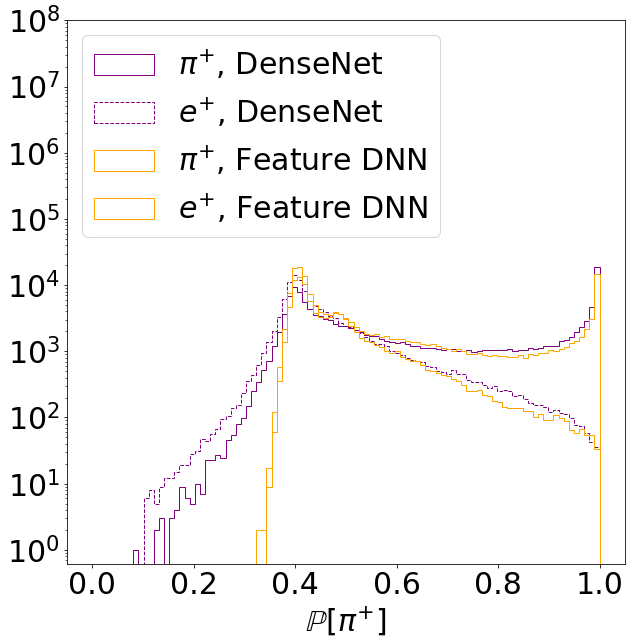

In [102]:
plt.figure(figsize=(10, 10))
bins = np.linspace(0, 1, 100)
# plt.hist(yhat_image_dnn[labels_test == 1], histtype='step', bins=bins, label=r'$\pi^{+}$, Image DNN', color='red')
# plt.hist(yhat_image_dnn[labels_test == 0], histtype='step', bins=bins, label=r'$e^{+}$, Image DNN', color='red',
#         linestyle='dashed')
plt.hist(yhat_dnet_merged[labels_test == 1], histtype='step',
         bins=bins, label=r'$\pi^{+}$, DenseNet', color='purple')
plt.hist(yhat_dnet_merged[labels_test == 0], histtype='step',
         bins=bins, label=r'$e^{+}$, DenseNet', color='purple',
        linestyle='dashed')
plt.hist(yhat_feature_dnn[labels_test == 1], histtype='step',
         bins=bins, label=r'$\pi^{+}$, Feature DNN', color='orange')
plt.hist(yhat_feature_dnn[labels_test == 0], histtype='step',
         bins=bins, label=r'$e^{+}$, Feature DNN', color='orange')
plt.legend(loc='upper left')
plt.yscale('log')
# plt.xlim((0.99999, 1))
# plt.xscale('log')
plt.ylim(ymax=1e8)
plt.xlabel(r'$\mathbb{P}[\pi^{+}]$')

In [ ]:
fpr_image_dnn, tpr_image_dnn, _ = roc_curve(labels_test, abs(1-yhat_image_dnn), pos_label=0)
# fpr_dnet, tpr_dnet, _ = roc_curve(labels_test, abs(1-yhat_dnet), pos_label=0)
# fpr_dnet0, tpr_dnet0, _ = roc_curve(labels_test, abs(1-yhat_dnet0), pos_label=0)
# fpr_dnet2, tpr_dnet2, _ = roc_curve(labels_test, abs(1-yhat_dnet2), pos_label=0)
# fpr_dnet_mean, tpr_dnet_mean, _ = roc_curve(labels_test,
#                                             abs(1 - ((yhat_dnet2 + yhat_dnet + yhat_dnet0)/3) ),
#                                             pos_label=0)

fpr_dnet_merged, tpr_dnet_merged, _ = roc_curve(labels_test, abs(1-yhat_dnet_merged), pos_label=0)
fpr_raveled_dnn, tpr_raveled_dnn, _ = roc_curve(labels_test, abs(1-yhat_raveled_dnn), pos_label=0)
fpr_feature_dnn, tpr_feature_dnn, _ = roc_curve(labels_test, abs(1-yhat_feature_dnn), pos_label=0)
# fpr_feature_bdt, tpr_feature_bdt, _ = roc_curve(labels_test, yhat_feature_bdt)


In [49]:
roc_curve?

In [ ]:
with h5py.File('{}-vs-{}-outputs.h5'.format(CLASS_ONE, CLASS_TWO), 'w') as h5:
    h5['y'] = labels_test
    h5['nn_image'] = yhat_image_dnn
    h5['nn_raveled'] = yhat_raveled_dnn
    h5['nn_showershapes'] = yhat_feature_dnn
    h5['bdt_showershapes'] = yhat_feature_bdt

In [ ]:
slices = np.linspace(0, 1, 10000000)

In [ ]:
tpr, _ = np.histogram(yhat[labels_test == 1], bins=slices)
fpr, _ = np.histogram(yhat[labels_test == 0], bins=slices)

In [ ]:
tpr = np.cumsum(tpr[::-1])[::-1]
fpr = np.cumsum(fpr[::-1])[::-1]

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(tpr_dnet_merged, 1 / fpr_dnet_merged, label='DenseNet',
        linewidth=2)
plt.plot(tpr_image_dnn, 1 / fpr_image_dnn, label='LAGAN-Style Discriminator',
        linewidth=2)
plt.plot(tpr_feature_dnn, 1 / fpr_feature_dnn, label='FCN on Shower Shapes',
        linewidth=2)
plt.plot(tpr_raveled_dnn, 1 / fpr_raveled_dnn, label='FCN on Unraveled Pixels',
        linewidth=2)


# plt.plot(tpr_dnet2, 1 / fpr_dnet2, label='DenseNet 2')
# plt.plot(tpr_dnet, 1 / fpr_dnet, label='DenseNet 1')
# plt.plot(tpr_dnet0, 1 / fpr_dnet0, label='DenseNet 0')
# plt.plot(tpr_dnet_mean, 1 / fpr_dnet_mean, label='DenseNet Mean')

# plt.yscale('log')
plt.grid('on', 'both')
plt.xlim((0.5, 1))
plt.ylim(1, 4)
plt.xlabel(r'$\varepsilon_{e^+}$')
plt.ylabel(r'1 / $\varepsilon_{\gamma}$')

# plt.xlabel('{} Efficiency'.format(CLASS_TWO))
# plt.ylabel('{} Background Rejection'.format(CLASS_ONE))
plt.legend(fontsize=23, loc='upper right')

In [160]:
wp = 0.9
print 'At 60% efficiency:'
print 'FCN on Shower Shapes --> {} rejection'.format(
    (1 / fpr_feature_dnn)[np.argmin(abs(tpr_feature_dnn - wp))])
print 'FCN on Unraveled Pixels --> {} rejection'.format(
    (1 / fpr_raveled_dnn)[np.argmin(abs(tpr_raveled_dnn - wp))])
print 'LAGAN-Style Discriminator --> {} rejection'.format(
    (1 / fpr_image_dnn)[np.argmin(abs(tpr_image_dnn - wp))])
print 'LAGAN-Style Discriminator --> {} rejection'.format(
    (1 / fpr_dnet_merged)[np.argmin(abs(tpr_dnet_merged - wp))])

At 60% efficiency:
FCN on Shower Shapes --> 1.69678683031 rejection
FCN on Unraveled Pixels --> 1.67576482691 rejection
LAGAN-Style Discriminator --> 1.80778277705 rejection
LAGAN-Style Discriminator --> 1.82753490641 rejection


/home/micky/.venvwrp/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/home/micky/.venvwrp/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/home/micky/.venvwrp/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/home/micky/.venvwrp/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.


In [153]:
np.argmin(abs(tpr_feature_dnn - 0.6))

63415

In [138]:
import pandas as pd
df = pd.DataFrame()
# df['Truth'] = labels_test
df['DenseNet'] = yhat_dnet_merged
df['LAGAN D'] = yhat_image_dnn
df['FCN Shower Shapes'] = yhat_feature_dnn
df['FCN Pixels'] = yhat_raveled_dnn

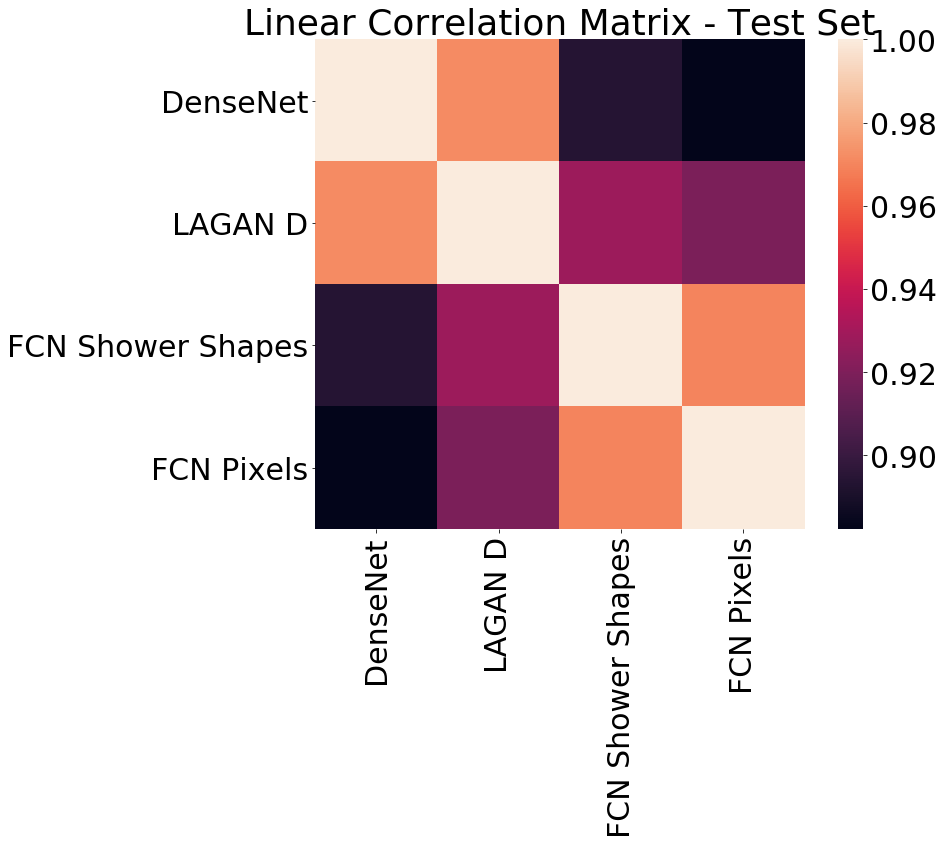

In [140]:
import seaborn as sns

corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1, square=True)
plt.title('Linear Correlation Matrix - Test Set')
#plt.savefig('../plots/oct25/correlation_test_low_stats.pdf')

In [119]:
from scipy import interpolate
from matplotlib import gridspec


In [120]:
def uix(a):
    return np.unique(a, return_index=True)[1]

In [ ]:
eff_interp = np.linspace(0.05, 1, 100)
# interp_image_dnn = np.interp(eff_interp, tpr_image_dnn, fpr_image_dnn)
# interp_feature_dnn = np.interp(eff_interp, tpr_feature_dnn, fpr_feature_dnn)
# interp_raveled_dnn = np.interp(eff_interp, tpr_raveled_dnn, fpr_raveled_dnn)

interp_image_dnn = interpolate.interp1d(
    tpr_image_dnn[uix(tpr_image_dnn)],
    fpr_image_dnn[uix(tpr_image_dnn)], kind='linear')(eff_interp)
interp_feature_dnn = interpolate.interp1d(
    tpr_feature_dnn[uix(tpr_feature_dnn)],
    fpr_feature_dnn[uix(tpr_feature_dnn)], kind='linear')(eff_interp)
# interp_raveled_dnn = interpolate.interp1d(tpr_raveled_dnn[uix(tpr_raveled_dnn)], fpr_raveled_dnn[uix(tpr_raveled_dnn)], kind='cubic')(eff_interp)

kern_size = 20
kern = [1 / float(kern_size)] * kern_size
interp_image_dnn = np.convolve(interp_image_dnn, kern, mode='same')
interp_feature_dnn = np.convolve(interp_feature_dnn, kern, mode='same')
# interp_raveled_dnn = np.convolve(interp_raveled_dnn, kern, mode='same')

In [ ]:
plt.figure(figsize=(7, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
ax = plt.subplot(gs[0])
plt.plot(tpr_image_dnn, fpr_image_dnn, label='ResNet on Calorimeter Hits')
plt.plot(tpr_feature_dnn, fpr_feature_dnn, label='DNN on Shower Shapes')
# plt.plot(tpr_raveled_dnn, fpr_raveled_dnn, label='Simple DNN on Calorimeter Hits')
plt.yscale('log')
plt.grid('on', 'both')
plt.xlim((0, 1))
plt.xlabel(r'$\pi^{+}$ efficiency')
plt.ylabel(r'$e^{+}$ efficiency')
plt.legend(loc='upper left')

plt.subplot(gs[1], sharex=ax)
plt.plot(eff_interp, interp_feature_dnn / interp_image_dnn, label='ResNet on Calorimeter Hits')
plt.plot(eff_interp, interp_feature_dnn / interp_feature_dnn, label='DNN on Shower Shapes')
# plt.plot(eff_interp, interp_feature_dnn / interp_raveled_dnn, label='Simple DNN on Calorimeter Hits')
# plt.yscale('log')
plt.grid('on', 'both')
# plt.xlim((0.99, 1))
# plt.xlabel(r'$\pi^{+}$ efficiency')
plt.ylabel(r'Ratio of $e^{+}$ efficiencies of DNN on Shower Shapes to X')
plt.legend(loc='upper left')

# Regression

In [164]:
def build_simple_dnn(x):

    h = Dense(512)(x)
    h = Dropout(0.2)(LeakyReLU()(h))
    #h = BatchNormalization()(h)

    h = Dense(1024)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    #h = BatchNormalization()(h)

#     h = Dense(2048)(h)
#     h = Dropout(0.5)(LeakyReLU()(h))
#     #h = BatchNormalization()(h)
    
    h = Dense(1024)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    #h = BatchNormalization()(h)

    h = Dense(128)(h)
    h = Dropout(0.5)(LeakyReLU()(h))

    y = Dense(4, activation='linear')(h)

    return y

In [165]:
x = Input(shape=(3*96+12*12+12*6, ))
y = build_simple_dnn(x)
model = Model(x, y)

In [189]:
model.compile('adam', 'mse')

ValueError: When passing a list as loss_weights, it should have one entry per model outputs. The model has 1 outputs, but you passed loss_weights=[1, 5, 1, 1]

In [178]:
d = h5py.File('../../fast/gamma_angle_position_5deg_xy.h5', 'r')

In [179]:
events = d['layer_0'][:].shape[0]
n_train = int(events * 0.6)
ravelled_data = np.concatenate(
       (
           d['layer_0'][:].reshape(events, -1),
           d['layer_1'][:].reshape(events, -1),
           d['layer_2'][:].reshape(events, -1)
       ), axis=-1)

train_data = ravelled_data[:n_train]
test_data = ravelled_data[n_train:]

In [180]:
p = np.sqrt(d['px'][:]**2 + d['py'][:]**2 + d['pz'][:]**2)
theta_A = np.arccos(d['py'][:] / p)
phi_A = np.arctan(-d['px'][:] / d['pz'][:])

In [182]:
try:
    model.fit(train_data / 75000, 
              np.concatenate(
                (phi_A[:n_train] / abs(phi_A[:n_train]).max(),
                theta_A[:n_train] / abs(theta_A[:n_train]).max(),
                d['x0'][:n_train] / abs(d['x0'][:n_train]).max(),
                d['y0'][:n_train] / abs(d['y0'][:n_train]).max()),
                axis=-1),
              callbacks=[
                  EarlyStopping(verbose=True, patience=20, monitor='val_loss'),
                  ModelCheckpoint('regr4-chkpt.h5',
                    monitor='val_loss', verbose=True, save_best_only=True)
              ],
              verbose=False, validation_split=0.3, batch_size=128, epochs=100)
except KeyboardInterrupt:
    print 'ending early'  

Epoch 00000: val_loss improved from inf to 0.06503, saving model to regr4-chkpt.h5
Epoch 00001: val_loss improved from 0.06503 to 0.05397, saving model to regr4-chkpt.h5
Epoch 00002: val_loss improved from 0.05397 to 0.05109, saving model to regr4-chkpt.h5
Epoch 00003: val_loss improved from 0.05109 to 0.04710, saving model to regr4-chkpt.h5
Epoch 00004: val_loss improved from 0.04710 to 0.04556, saving model to regr4-chkpt.h5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.04556 to 0.04354, saving model to regr4-chkpt.h5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.04354 to 0.04098, saving model to regr4-chkpt.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 0.04098 to 0.04061, saving model to regr4-chkpt.h5
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoc

In [190]:
model.load_weights('regr4-chkpt.h5')

In [191]:
phihat = model.predict(test_data / 75000)

In [192]:
phihat[:, 0] *= abs(phi_A[:n_train]).max()
phihat[:, 1] *= abs(theta_A[:n_train]).max()
phihat[:, 2] *= abs(d['x0'][:n_train]).max()
phihat[:, 3] *= abs(d['x0'][:n_train]).max()

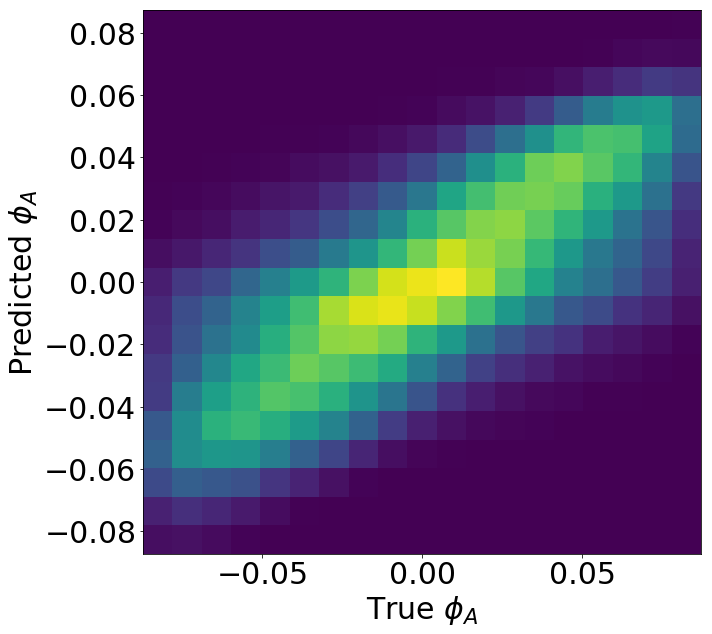

In [193]:
plt.figure(figsize=(10,10))
_ = plt.hist2d(phi_A[n_train:].ravel(), phihat[:, 0].ravel(),
               bins=np.linspace(phi_A.min(), phi_A.max(), 20))
plt.xlabel(r'True $\phi_A$')
plt.ylabel(r'Predicted $\phi_A$')

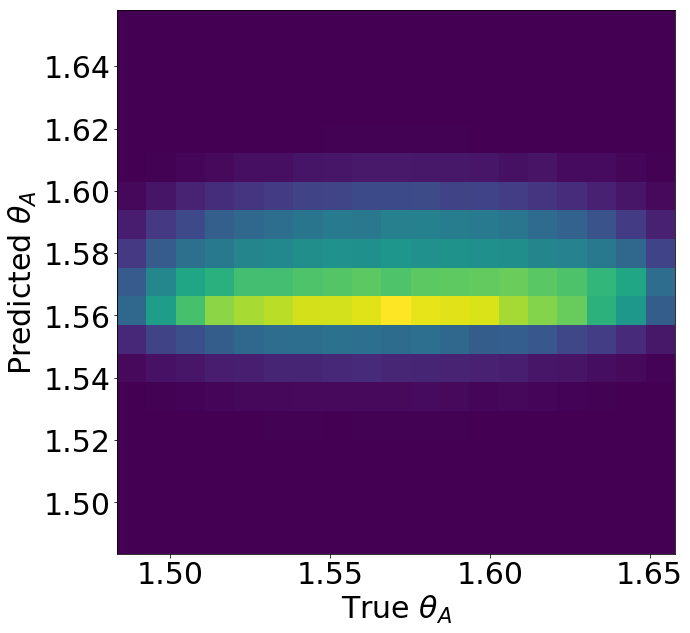

In [194]:
plt.figure(figsize=(10,10))
_ = plt.hist2d(theta_A[n_train:].ravel(), phihat[:, 1].ravel(),
               bins=np.linspace(theta_A.min(), theta_A.max(), 20))
plt.xlabel(r'True $\theta_A$')
plt.ylabel(r'Predicted $\theta_A$')

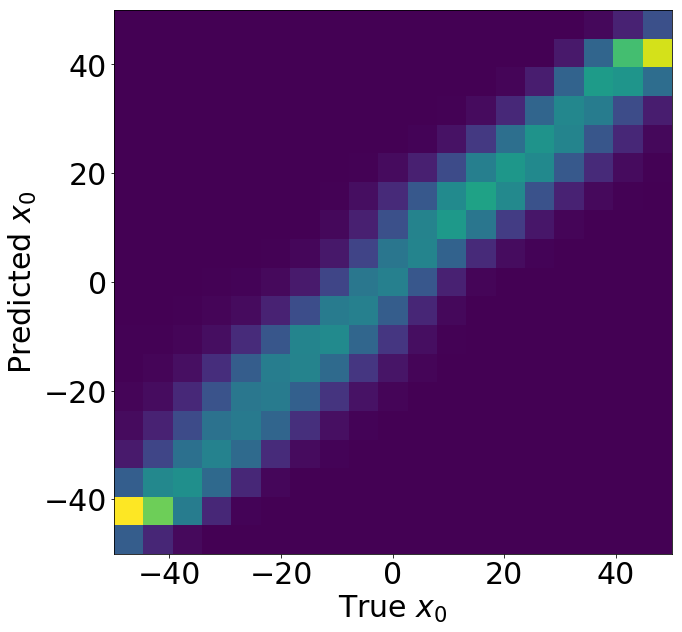

In [195]:
plt.figure(figsize=(10,10))
_ = plt.hist2d(d['x0'][n_train:].ravel(), phihat[:, 2].ravel(),
               bins=np.linspace(d['x0'][n_train:].min(), d['x0'][n_train:].max(), 20))
plt.xlabel(r'True $x_0$')
plt.ylabel(r'Predicted $x_0$')

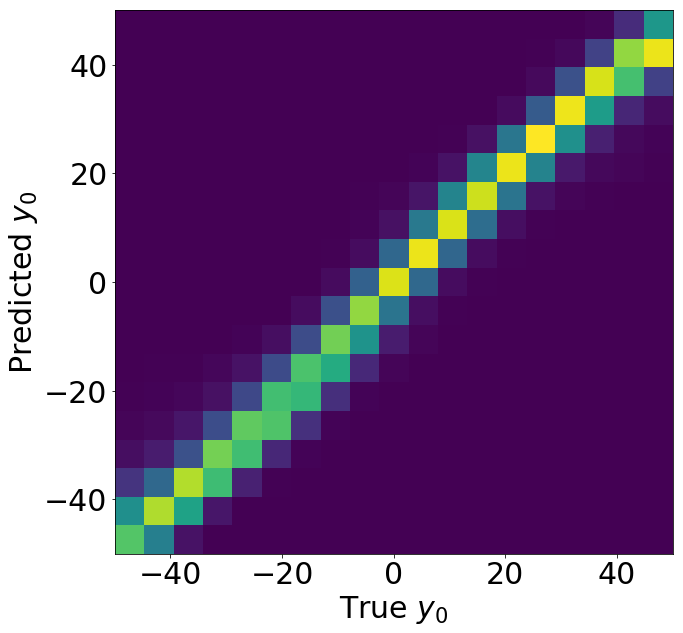

In [196]:
plt.figure(figsize=(10,10))
_ = plt.hist2d(d['y0'][n_train:].ravel(), phihat[:, 3].ravel(),
               bins=np.linspace(d['y0'][n_train:].min(), d['y0'][n_train:].max(), 20))
plt.xlabel(r'True $y_0$')
plt.ylabel(r'Predicted $y_0$')